# Aufgabenblatt 3: Numerische Lösung

In [6]:
using DotMaps
using CairoMakie
using IntervalSets
using MMJMesh.Plots
using MMJMesh.Mathematics

## Problemparameter

In [7]:
# Mehrfachvariable
p = DotMap()

# Basiswerte
p.E = 35e9
p.d = 0.8
p.l = 20
p.F = 2e6
p.ρ = 2500
p.g = 9.81
p.S = 120e6
p.c = 1.75e7

# Abgeleitete Werte
p.Ω = 0 .. p.l
p.C = p.c * π * p.d
p.A = π * p.d^2 / 4
p.EA = p.E * p.A
p.n = p.ρ * p.g * p.A;

## Exakte Lösung

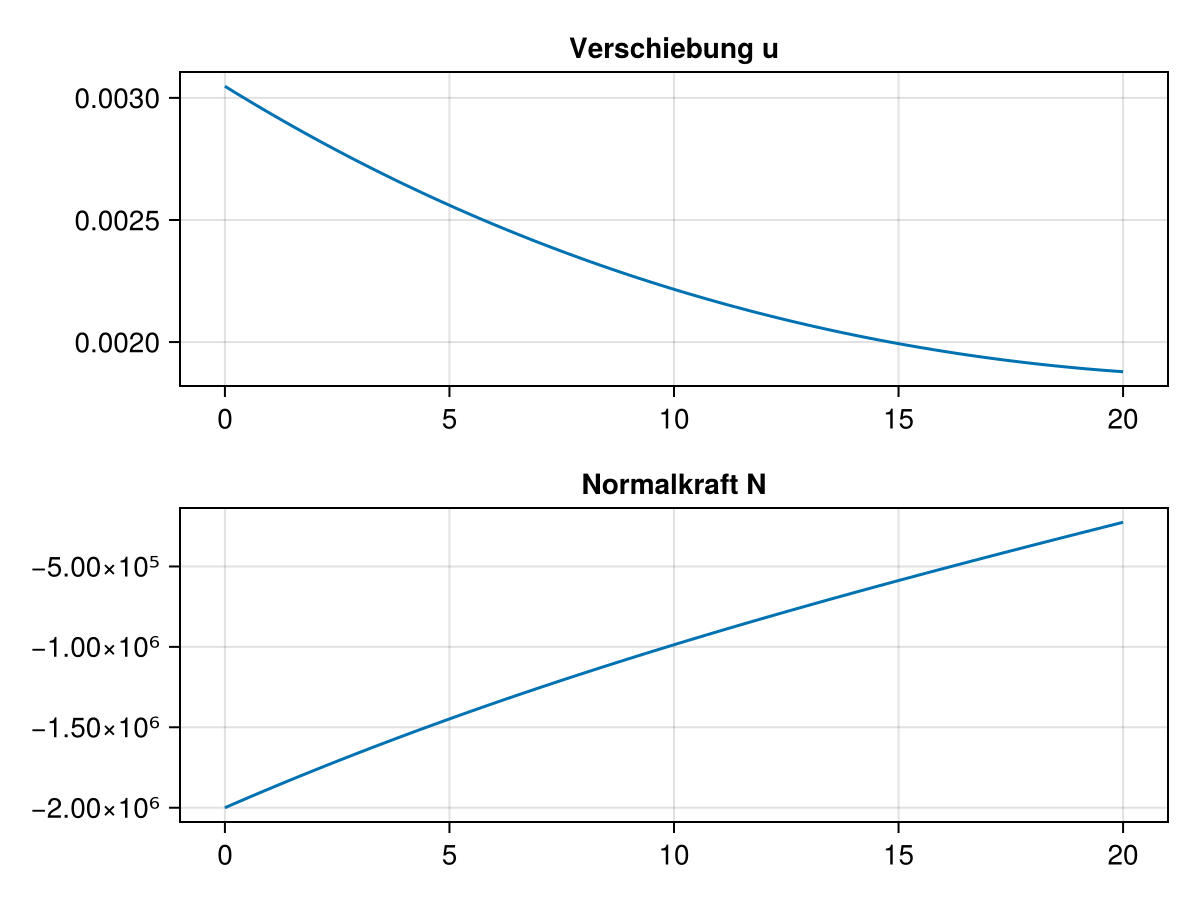

In [8]:
a1 = 3 + 7π
a2 = 7π - 3
x = variable(p.Ω)

u = 1 / (3500000 * π * (a1 * ℯ^2 - a2)) * exp(-x / 20) * (
        25000 * (a1 * ℯ^2 + a2 * exp(x / 10))
        -
        2943 * π * ℯ * (exp(x / 10) + 1)
        +
        981 * π * exp(x / 20) * (a1 * ℯ^2 - a2)
    )

N = p.EA * u'

fig = Figure()
fplot!(Axis(fig[1, 1], title="Verschiebung u"), u, npoints=100)
fplot!(Axis(fig[2, 1], title="Normalkraft N"), N, npoints=100)
fig

## Kontrolle starke Form

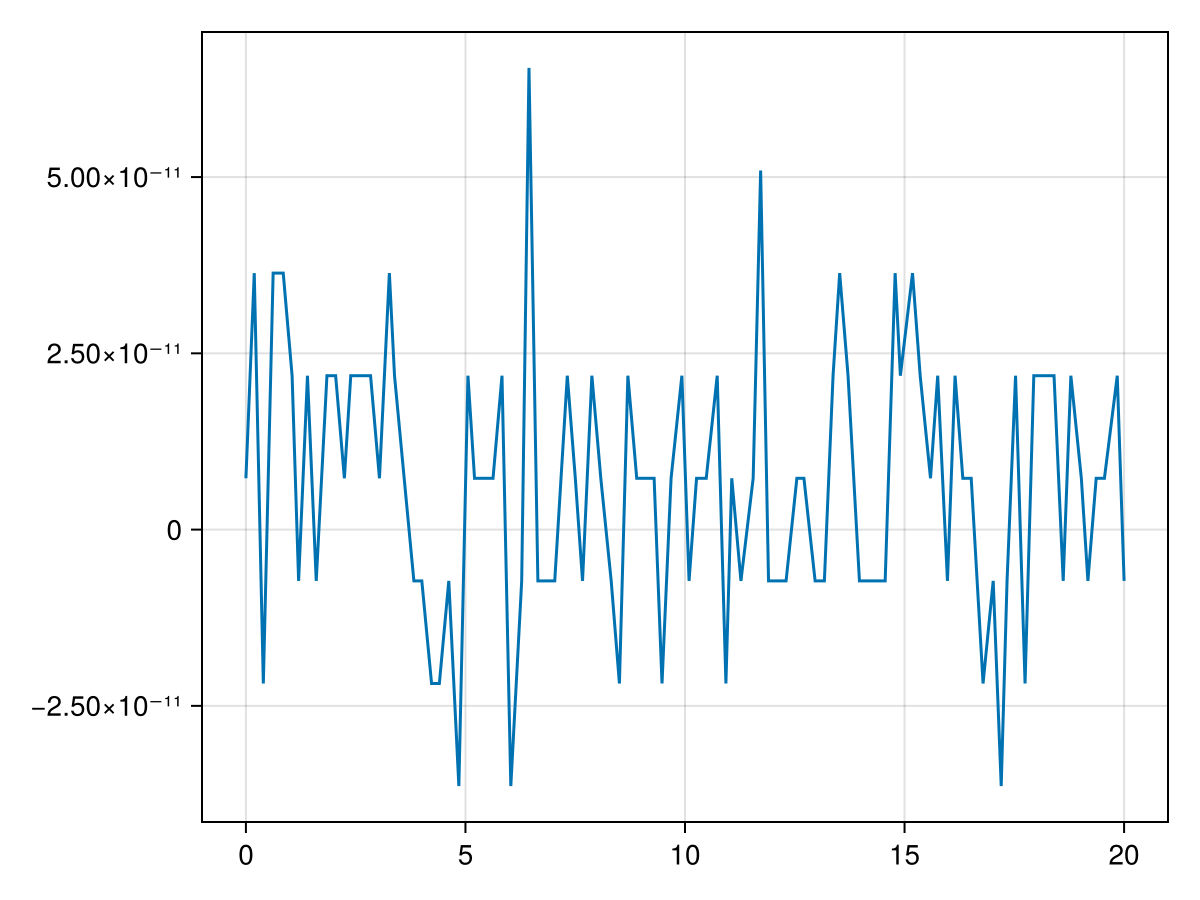

In [36]:
fplot(p.EA * u'' - p.C * u + p.n, npoints = 100)

In [37]:
p.EA * u'(0) + p.F

-4.656612873077393e-10

In [38]:
p.EA * u'(p.l) + p.S * u(p.l)

2.0372681319713593e-10

## Schwache Form und Kontrolle

Bilineaer- und Linearform

In [39]:
a(u, δu) = integrate(p.EA * u' * δu' + p.C * u * δu, p.Ω) + p.S * u(p.l) * δu(p.l)
b(δu) = integrate(p.n * δu, p.Ω) + p.F * δu(0)

b (generic function with 1 method)

Test schwache Form für ausgewählte Funktionen

In [ ]:
diff_weak(f) = 100 * abs((a(u, f) - b(f))) / abs(a(u, f))

x = variable(p.Ω)
println("sin(x): ", diff_weak(sin(x)))
println("cos(x): ", diff_weak(cos(x)))
println("    x : ", diff_weak(x))
println("  x^2 : ", diff_weak(Polynomial(0, 0, 1)))


sin(x): 1.4321213828028188e-11
cos(x): 3.4729168007570823e-14
    x : 9.443462752492612e-14
  x^2 : 2.266431060598225e-14


## Numerische Lösung

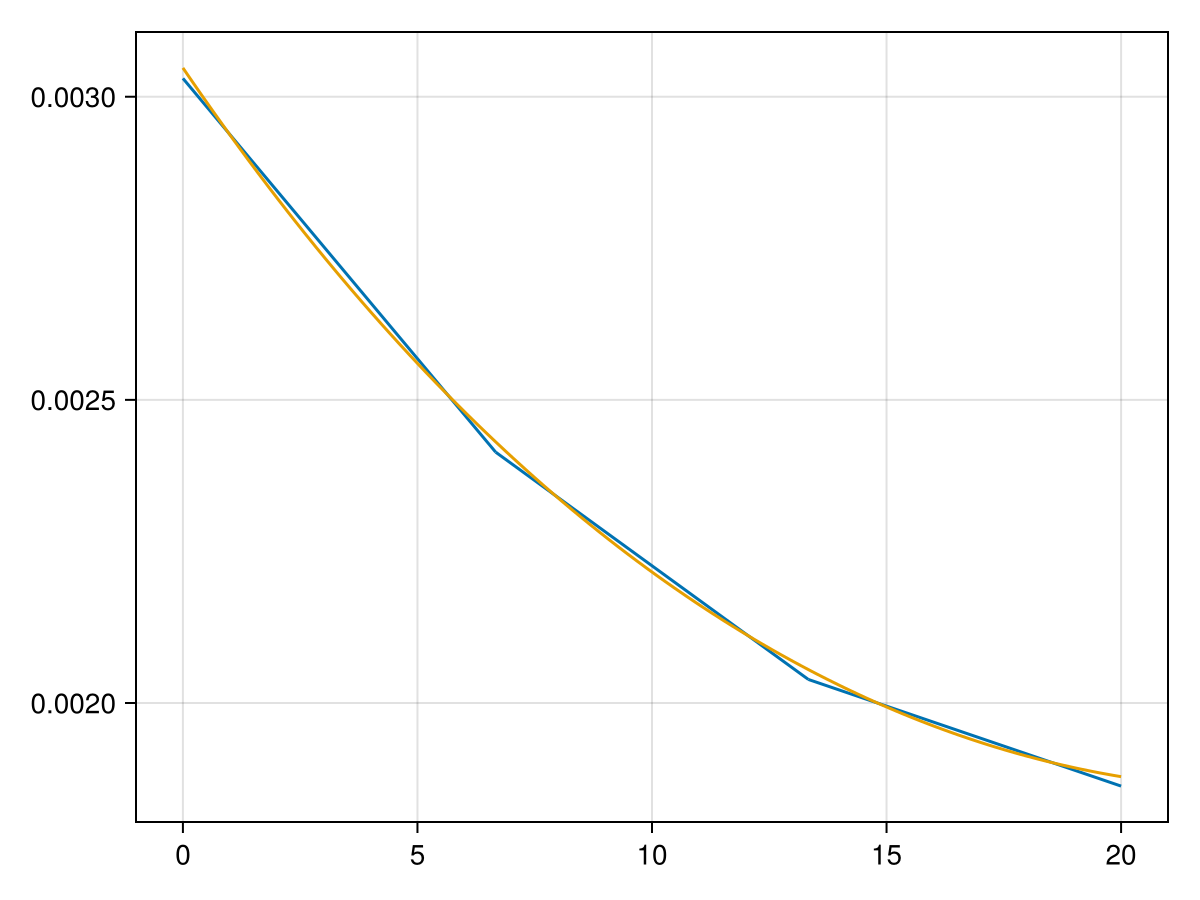

In [41]:
function pile_fem(p, k)
    phis = hatfunctions(range(p.Ω, k + 1))
    K = [a(phiᵢ, phiⱼ) for phiᵢ = phis, phiⱼ = phis]
    r = [b(phiᵢ) for phiᵢ = phis]
    uHat = K \ r
    uh = sum(uHat .* phis)
    return uh
end

uh = pile_fem(p, 3)
fplot(uh, u, npoints=100)

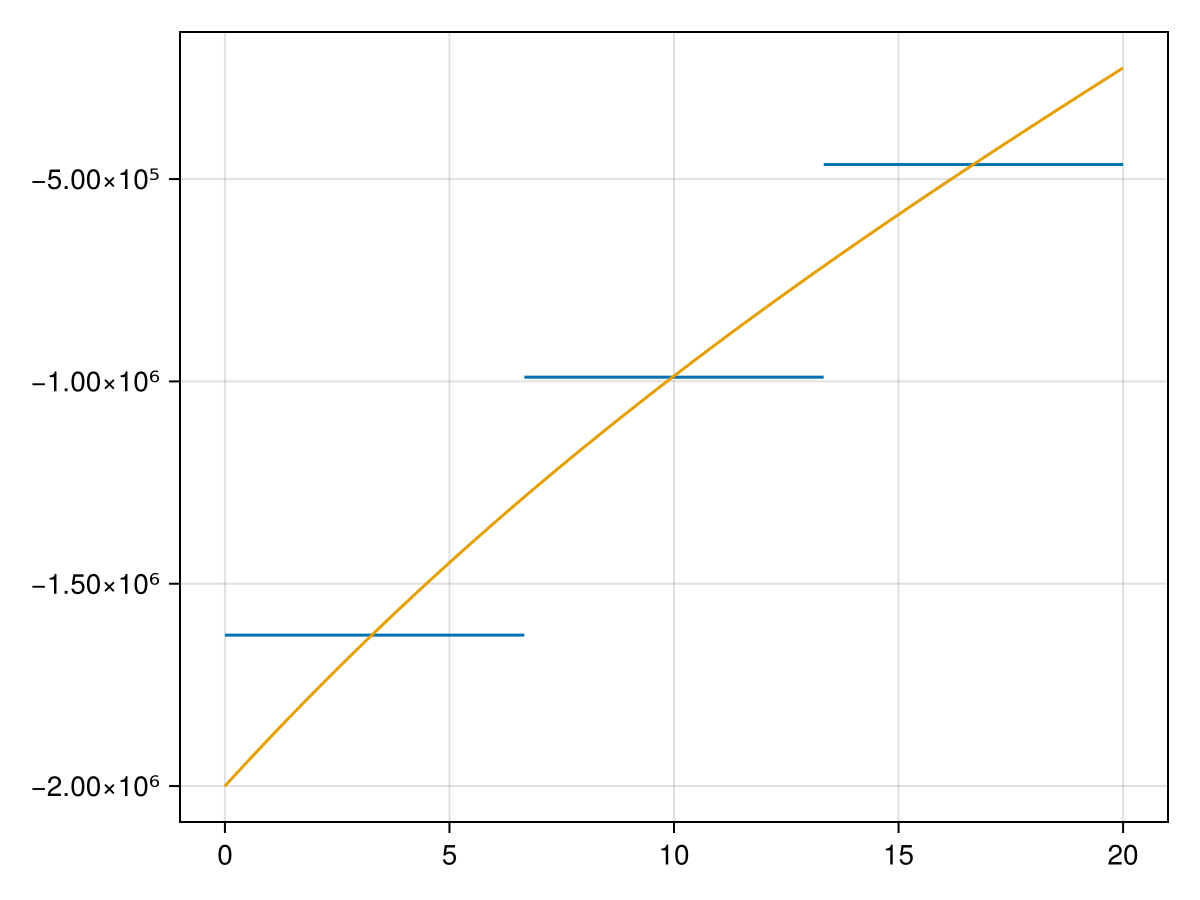

In [42]:
Nh = p.EA * uh'
fplot(Nh, N, npoints=100)

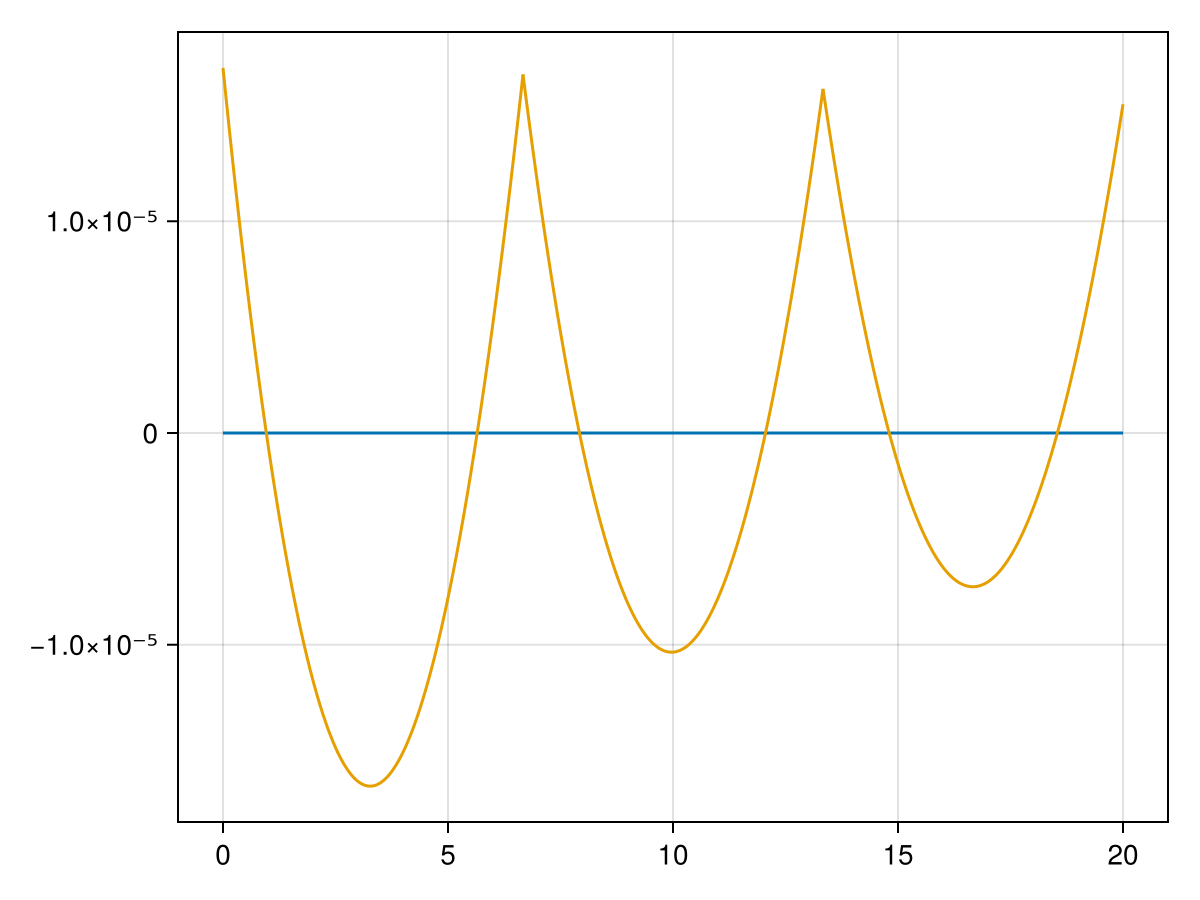

In [43]:
fplot(0 * x, u - uh, npoints=100)

## Konvergenz

Fehlerfunktion

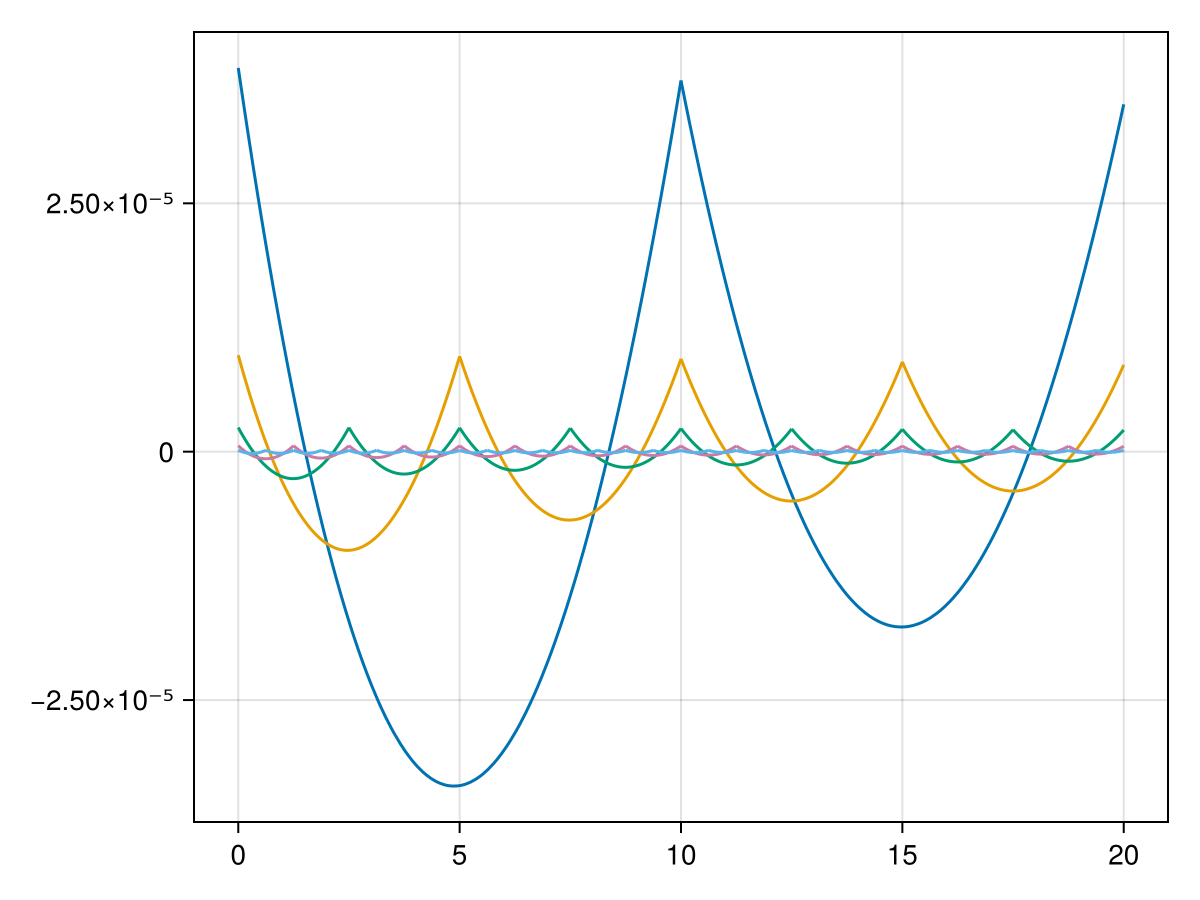

In [44]:
fig = Figure()
Axis(fig[1, 1])
for k = 2 .^ (1:5)
    uh = pile_fem(p, k)
    fplot!(u - uh, npoints=100)
end

fig

Normalkraft

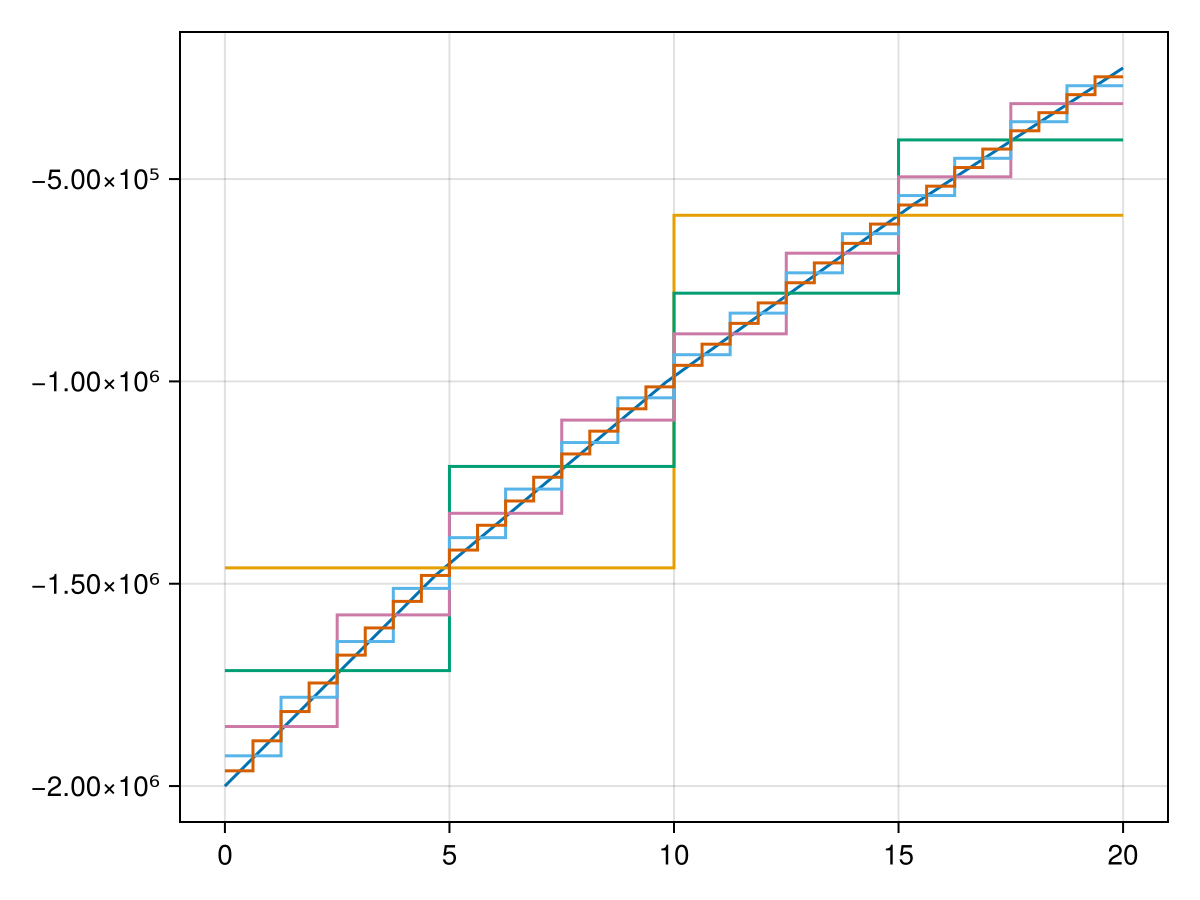

In [48]:
fig = Figure()
Axis(fig[1, 1])

fplot!(N)
for k = 2 .^ (1:5)
    uh = pile_fem(p, k)
    Nh = p.EA * uh'
    fplot!(Nh, connect_jumps=true)
end

fig

Fehler in max-Norm

In [55]:
nn = 6
hks = zeros(nn)
eks = zeros(nn)

maxnorm(u) = maximum(abs.(u.(range(domain(u), 1000))))

for i in 1:nn
    k = 2^i
    uh = pile_fem(p, k)
    hks[i] = p.l / k
    eks[i] = 100 * maxnorm(u - uh) / maxnorm(u)
end

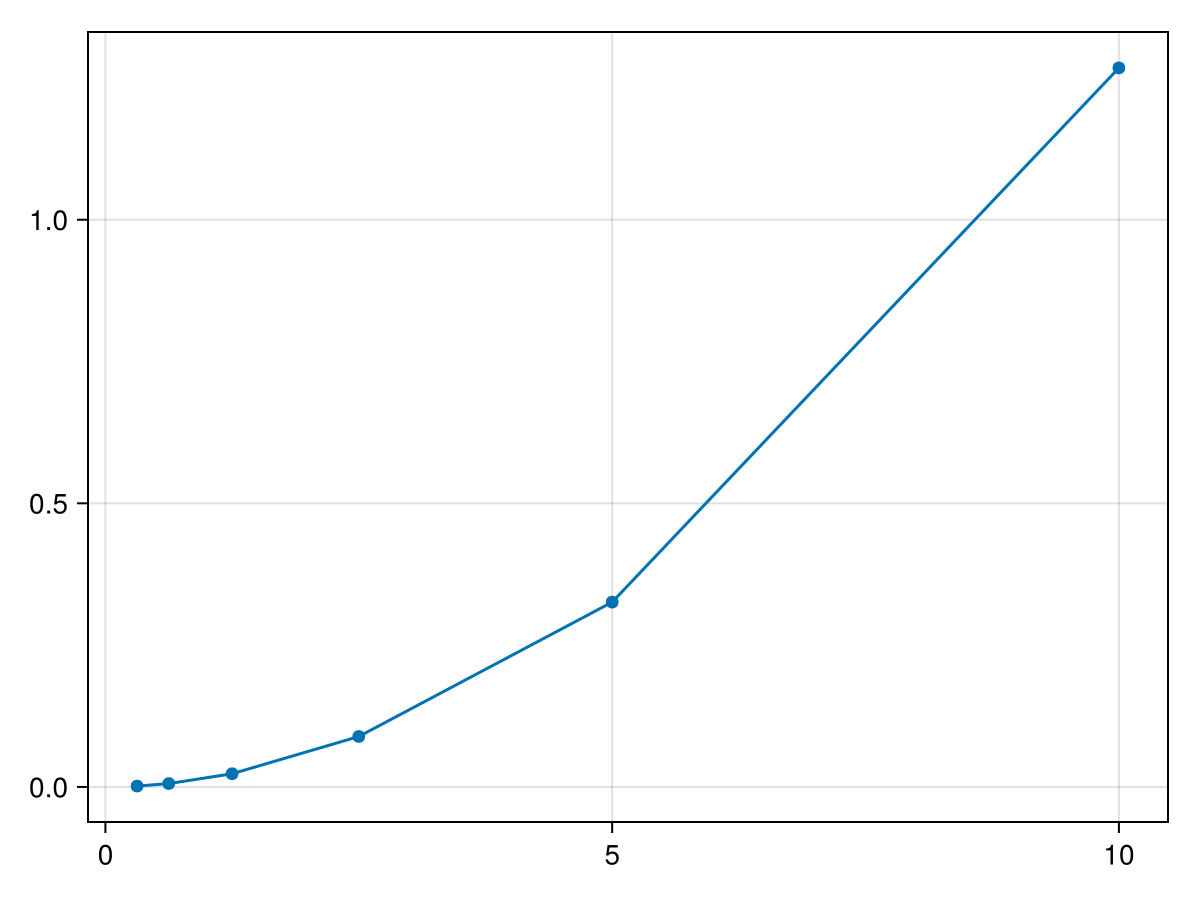

In [56]:
scatterlines(hks, eks)

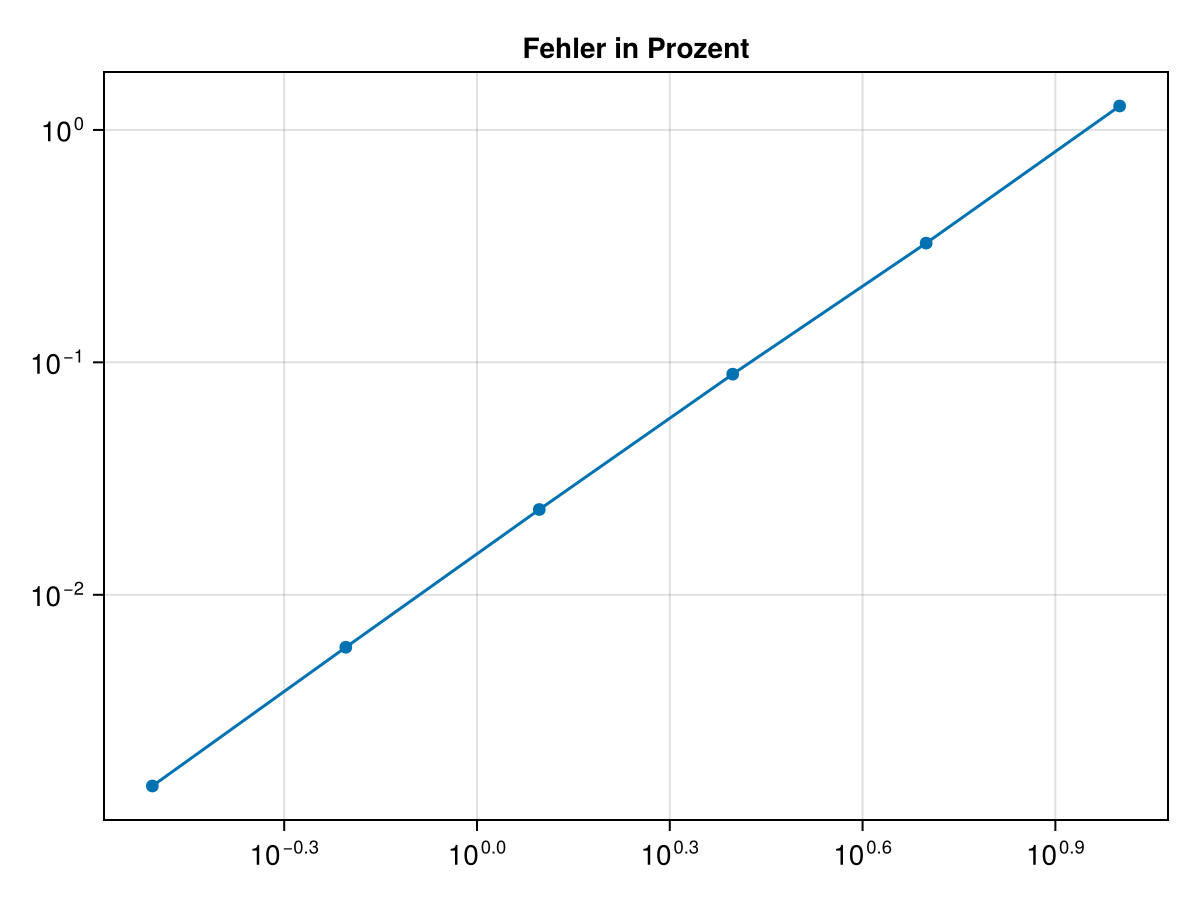

In [57]:
f = Figure()
Axis(f[1, 1], xscale=log10, yscale=log10, title="Fehler in Prozent")
scatterlines!(hks, eks)
f